In [1]:
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs


In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
sys.path.insert(0, "../python")
import BayesianOptimizationCustom as bo

In [46]:
optimizer_custum = bo.BayesianOptimizationCustom('../config/params_type.json', None, None,
                                                 'output', 'output', 10, 1, 1)
params_range = optimizer_custum.ParamsRange()
params_range

{'num_den_layers_pre': (0, 5),
 'num_units_den_layers_pre': (15, 60),
 'dropout_rate_den_layers_pre': (0, 0.5),
 'num_den_layers_post': (0, 5),
 'num_units_den_layers_post': (15, 60),
 'dropout_rate_den_layers_post': (0, 0.5),
 'num_rnn_layers': (3, 10),
 'num_units_rnn_layer': (20, 200),
 'activation_dense_pre': (0, 2),
 'rnn_type': (0, 2),
 'activation_dense_post': (0, 2),
 'dropout_rate_rnn': (0, 0.5),
 'learning_rate_exp': (-6, -1),
 'optimizers': (0, 3)}

In [96]:
optimizer = BayesianOptimization(
    f=None,
    pbounds=params_range,
    random_state=1, verbose=1
)
# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["../python/17_11_2019_v9_opt.json"])

In [48]:
optimizer._gp.fit(optimizer._space.params, optimizer._space.target)

GaussianProcessRegressor(alpha=1e-06, copy_X_train=True,
                         kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=25, normalize_y=True,
                         optimizer='fmin_l_bfgs_b',
                         random_state=RandomState(MT19937) at 0x7FBB8E67D990)

In [49]:
optimizer._space.params.shape

(40, 14)

In [50]:
optimizer._space.keys

['activation_dense_post',
 'activation_dense_pre',
 'dropout_rate_den_layers_post',
 'dropout_rate_den_layers_pre',
 'dropout_rate_rnn',
 'learning_rate_exp',
 'num_den_layers_post',
 'num_den_layers_pre',
 'num_rnn_layers',
 'num_units_den_layers_post',
 'num_units_den_layers_pre',
 'num_units_rnn_layer',
 'optimizers',
 'rnn_type']

In [78]:
params = {'activation_dense_post' : 0, 'activation_dense_pre': 1, 'dropout_rate_den_layers_post' : 2,
          'dropout_rate_den_layers_pre' : 3, 'dropout_rate_rnn': 4, 'learning_rate_exp': 5, 'num_den_layers_post': 6, 
          'num_den_layers_pre': 7, 'num_rnn_layers': 8, 'num_units_den_layers_post': 9, 
          'num_units_den_layers_pre': 10, 'num_units_rnn_layer': 11, 'optimizers': 12, 
          'rnn_type': 13} 

In [51]:
max_point = optimizer._space.params[optimizer._space.target.argmax()]
max_point

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.15, -3.  ,  0.  ,  0.  ,  5.  ,
       15.  , 15.  , 74.  ,  2.  ,  0.  ])

In [93]:
def CreatePlots(var, pdf, n_bin, plot_title):
    var_points = np.linspace(params_range[var][0], params_range[var][1], 1000)#np.array([0, 1, 2, 3, 4, 5])
    x = np.zeros((var_points.shape[0], max_point.shape[0]))
    for n in range(x.shape[0]):
        x[n, :] = max_point[:]
        x[n, params[var]] = var_points[n]
    mu, sigma = optimizer._gp.predict(x, return_std=True)
    fig = plt.figure(figsize=(7, 6))
    ax = plt.gca()
    ax.plot(var_points, mu, '--', color='k', label='Prediction')
    ax.fill(np.concatenate([var_points, var_points[::-1]]), 
        np.concatenate([mu - 2 * sigma, (mu + 2 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval', color='yellow')
    ax.fill(np.concatenate([var_points, var_points[::-1]]), 
        np.concatenate([mu - 1 * sigma, (mu + 1 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='68% confidence interval', color='green')
    ax.set_ylabel('Purity')
    ax.set_xlabel(plot_title)
    plt.title(plot_title)
    ax.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    plt.draw()
    plt.show()
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


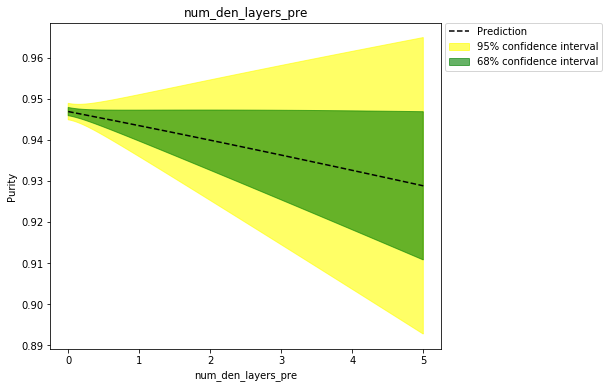

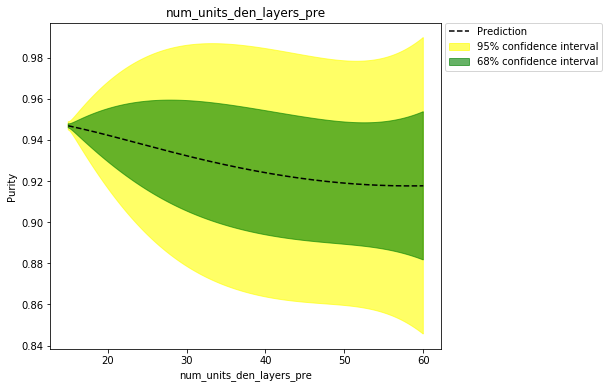

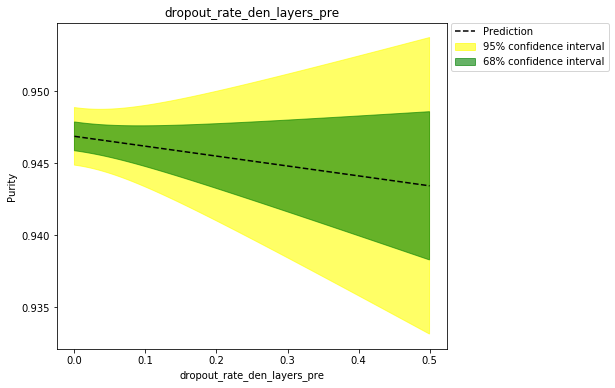

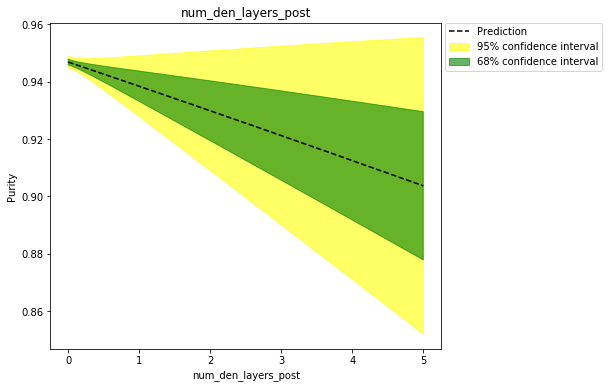

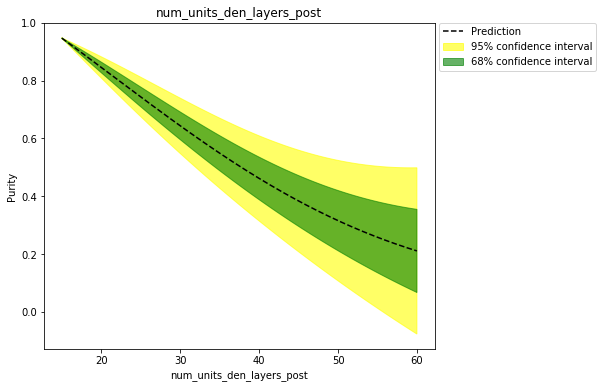

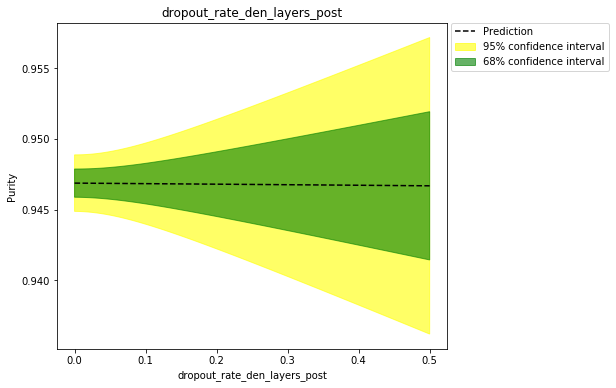

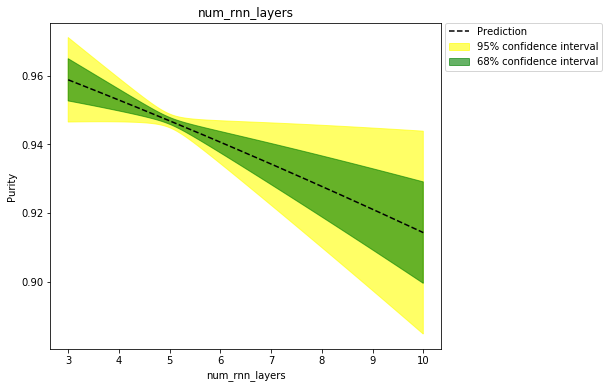

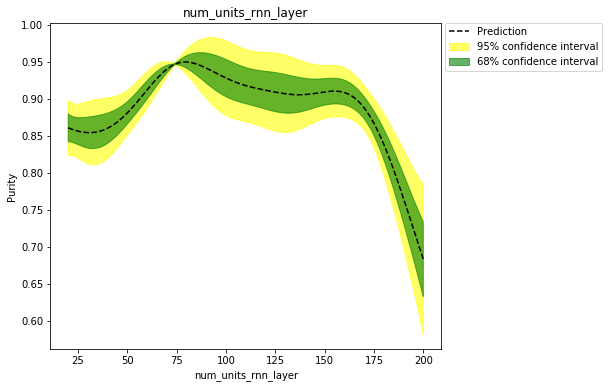

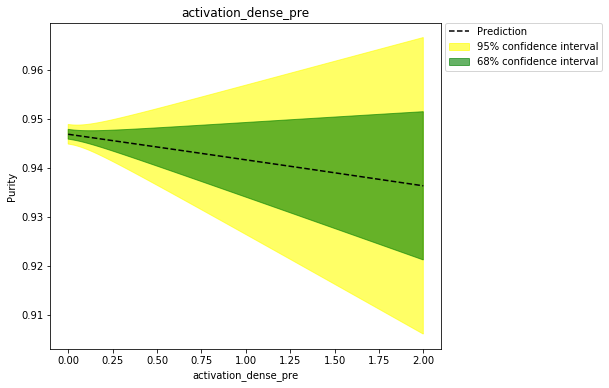

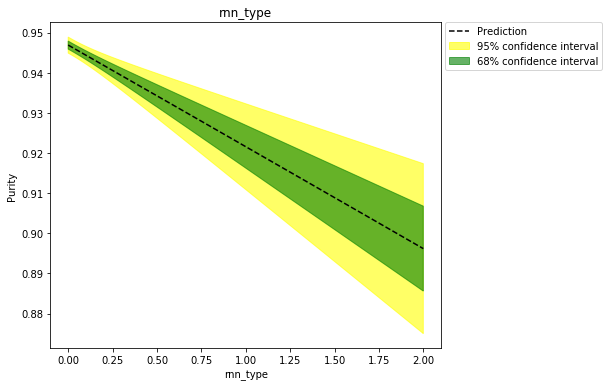

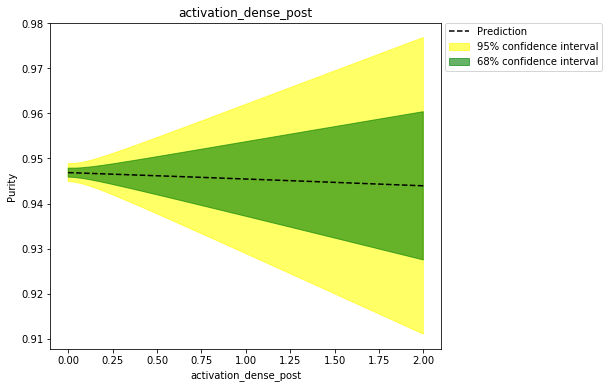

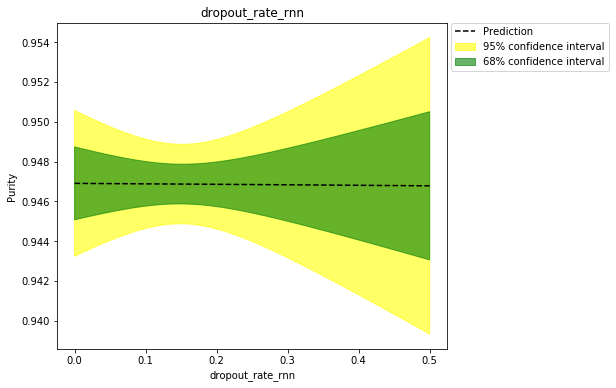

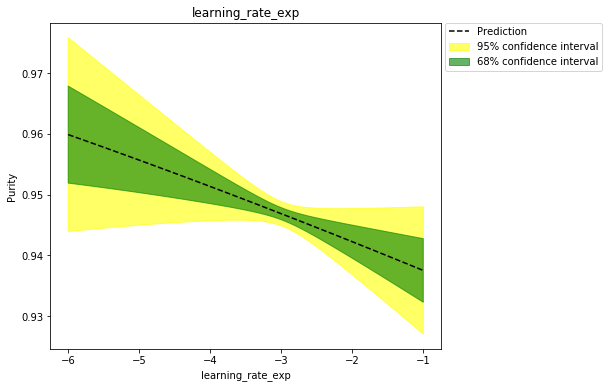

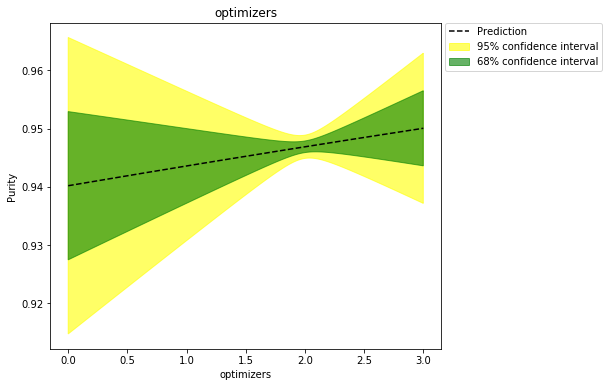

In [94]:
with PdfPages('params.pdf') as pdf:
    for key,values in params_range.items():
        CreatePlots(key, pdf, 'n_bin', key)
